In [1]:
# Import 
import os
import time
import json
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet#, SheetGeometry as geom
from tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.dynamics import SheetModel as basemodel
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')
import ipyvolume as ipv
ipv.clear()

In [2]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test_apoptosis')
dirname = SIM_DIR/'1.08_constriction_50_radialtension0/'
from tyssue.draw import sheet_view

import ipyvolume.pylab as p3
hfs = [f  for f in os.listdir(dirname)
       if f.endswith('hf5')]
hfs.sort(key=lambda x: os.path.getctime(os.path.join(dirname, x)))

current = 'invagination_0004.hf5'
ipv.clear()
ipv.style.use('dark')


dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face', 'cell'])

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('ellipse', dsets, specs)
"""sheet.face_df['test']=0
index =sheet.face_df[(sheet.face_df.z>6) & (sheet.face_df.z<15) 
              & (sheet.face_df.y>25) & (sheet.face_df.y<35) 
                    & (sheet.face_df.x>0)].index
sheet.face_df.loc[index, 'test']=1"""

#sheet = sheet.extract_bounding_box(z_boundary=[-200,50])
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.vert_df.y,
            #'colormap': 'Reds'
        },
        'face': {
            'visible': True,
            'color': sheet.face_df.fold,
            'colormap': 'Blues'
        },
        'vert':{
            'visible':True,
            's':100,
            'alpha': 0.3,
            'zorder': 2,
            'color': sheet.vert_df.radial_tension
            
        }
        
    }
    return specs

ipv.clear()
ipv_fig, meshes = sheet_view(sheet, coords=list('zxy'),
                             mode='3D', **draw_specs(sheet))
ipv_fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[0.983868, 0.904867, 0.136897],
       [0.983868, 0.904867, 0.136897],
       [0.974417, 0.90359 , 0.130215],
       ...,
       [0.267968, 0.223549, 0.512008],
       [0.13777 , 0.537492, 0.554906],
       [0.14618 , 0.515413, 0.556823]]), lines=array([[2454, 1907],
       [ 713,  529],
       [ 359, 2845],
       ...,
       [1479, 3299],
       [3299,  127],
       [ 127, 3299]], dtype=uint32), texture=None, x=array([-14.91590758,  -6.00497372,  -4.36477302, ...,  57.02227827,
        56.66774006,  49.10981736]), y=array([ -7.5860183 ,   8.44176221, -10.39666222, ...,  34.48238132,
       -50.44085377, -52.88103445]), z=array([ 58.98342597,  59.0560137 ,  58.76217355, ..., -39.93801051,
        -3.19158487,  -6.38365593])), Mesh(color=array([[0.96862745, 0.98431373, 1.        ],
       [0.96862745, 0.98431373, 1.        ],
       [0.67189542, 0.81437908, 0.90065359],
       ...,
       [0.96862745, 0.98431373, 1.        ],
       [0.96862745, 0.98431373, 1.        ],
       [0.96862745, 0.98431373, 1.        ]]), texture=None, triangles=array([[    0,  1652, 11552],
       [ 1632,  1653, 11553],
       [  178,  1654, 11554],
       ...,
       [ 1396, 11549, 21449],
       [  728, 11550, 21450],
       [ 1651, 11551, 21451]], dtype=uint32), x=array([-14.40068672, -12.59409033, -23.30405919, ...,  49.10981736,
        53.89423725,  49.10981736]), y=array([ -3.5231907 , -10.17644074, -14.34042076, ..., -52.88103445,
       -51.04543392, -52.88103445]), z=array([59.10944493, 58.67627716, 56.63785281, ..., -6.38365593,
       -7.06086906, -6.38365593]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-97.57876215292805, 97.59678963692852], ylim=[-97.57876215292805, 97.59678963692852], zlim=[-97.57876215292805, 97.59678963692852])

/home/admin-suz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


107.5


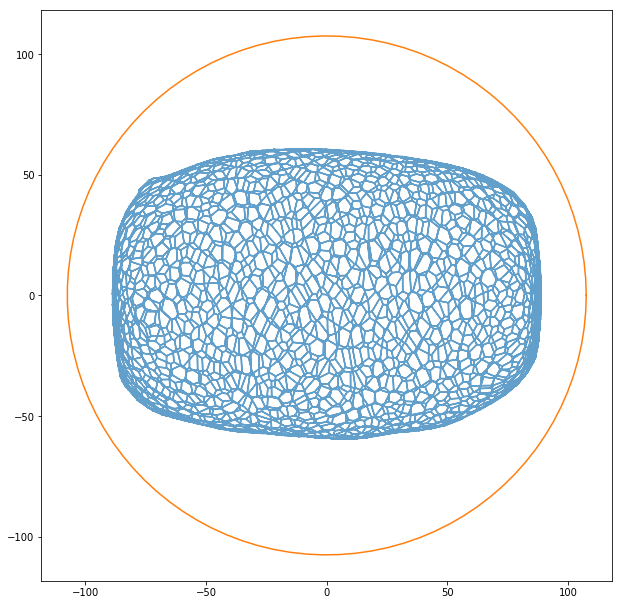

In [13]:
t = 40
file_name = 'invagination_{:04d}.csv'.format(t)
df = pd.DataFrame.from_csv(os.path.join(dirname, file_name))

fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)
theta = np.linspace(0, 2*np.pi, 100)

x = np.cos(theta)*float(df['0'].barrier_ray)
y = np.sin(theta)*float(df['0'].barrier_ray)
ax.plot(x,y)
print(float(df['0'].barrier_ray))
fig.set_size_inches(18.5, 10.5, forward=True)

In [18]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test_apoptosis')
dirname = SIM_DIR/'1.08_constriction_50_radialtension0/'

hfs = [f  for f in os.listdir(dirname) if f.endswith('hf5')]
hfs.sort()
from tyssue.draw.ipv_draw import edge_mesh, face_mesh

def get_meshes(dirname, hdf_file):
    dsets = hdf5.load_datasets(os.path.join(dirname, hdf_file),
                               data_names=['vert', 'edge', 'face'])
        
    sheet = Sheet('ellipse', dsets)
    faces = face_mesh(sheet, coords=['x', 'y', 'z'],
                      color=sheet.face_df['apoptosis'],
                      color_range=(0, 3),
                     colormap = 'Reds')
    
    #edges = edge_mesh(sheet, coords=['x', 'y', 'z'], color='grey')
    sheet.edge_df['color']=0    
    sheet.edge_df.loc[sheet.edge_df.face.isin(sheet.face_df[sheet.face_df.fold>0].index), 'color']=1
    edges = edge_mesh(sheet, coords=['x', 'y', 'z'],
                  color = sheet.edge_df.color,
                  color_range=(0,1),
                  colormap='seismic')
    return faces, edges

from ipywidgets import interact

def browse_sheets(dirname, hfs):
    n = len(hfs)
    ipv.clear()
    fig = ipv.gcf()
    meshes = get_meshes(dirname, hfs[0])
    fig.meshes = fig.meshes + list(meshes)
    
    def view_sheet(i):
        fig.animation = 0
        faces, edges = get_meshes(dirname, hfs[i])
        print()
        fig.meshes[0].x = faces.x
        fig.meshes[0].y = faces.y
        fig.meshes[0].z = faces.z
        fig.meshes[0].color = faces.color
        fig.meshes[0].triangles = faces.triangles

        fig.meshes[1].x = edges.x
        fig.meshes[1].y = edges.y
        fig.meshes[1].z = edges.z
        fig.meshes[1].color = edges.color
        fig.meshes[1].lines = edges.lines

        lim_inf = sheet.vert_df[sheet.coords].min().min()
        lim_sup = sheet.vert_df[sheet.coords].max().max()
        ipv.xyzlim(lim_inf, lim_sup)
    ipv.show()
    interact(view_sheet, i=(0, n-1))

In [19]:
browse_sheets(dirname, hfs)

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       [0.89019608, 0.18562092, 0.15294118],
       ...,
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647],
       [1.        , 0.96078431, 0.94117647]]), texture=None, triangles=array([[    0,  1652, 11552],
       [ 1632,  1653, 11553],
       [  178,  1654, 11554],
       ...,
       [ 1396, 11549, 21449],
       [  728, 11550, 21450],
       [ 1651, 11551, 21451]], dtype=uint32), x=array([ -3.47880938, -10.24294939, -14.49316636, ..., -53.8311406 ,
       -51.96152166, -53.8311406 ]), y=array([59.99687762, 59.53773118, 57.63111462, ..., -6.52298489,
       -7.18773134, -6.52298489]), z=array([-14.3913701 , -12.55690212, -23.2885628 , ...,  49.81712563,
        54.54209233,  49.81712563])), Mesh(color=array([[0. , 0. , 0.3],
       [0. , 0. , 0.3],
       [0. , 0. , 0.3],
       ...,
       [0. , 0. , 0.3],
       [0. , 0. , 0.3],
       [0. , 0. , 0.3]]), lines=array([[2454, 1907],
       [ 713,  529],
       [ 359, 2845],
       ...,
       [1479, 3299],
       [3299,  127],
       [ 127, 3299]], dtype=uint32), texture=None, x=array([ -7.60144445,   8.69451974, -10.42822707, ...,  35.08537243,
       -51.31938415, -53.8311406 ]), y=array([ 59.82869133,  59.97855234,  59.72823867, ..., -40.54117632,
        -3.25889996,  -6.52298489]), z=array([-14.92272667,  -6.02658243,  -4.29664545, ...,  57.38013916,
        57.33000519,  49.81712563]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[0.0, 1.0], ylim=[0.0, 1.0], zlim=[0.0, 1.0]),))

interactive(children=(IntSlider(value=2, description='i', max=4), Output()), _dom_classes=('widget-interact',))

In [ ]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test_apoptosis')
dirname = SIM_DIR/'1.08_constriction_50_radialtension0/'
from tyssue.draw import sheet_view

import ipyvolume.pylab as p3
hfs = [f  for f in os.listdir(dirname)
       if f.endswith('hf5')]
hfs.sort(key=lambda x: os.path.getctime(os.path.join(dirname, x)))

current = 'invagination_0070.hf5'
ipv.clear()
ipv.style.use('dark')


dsets = hdf5.load_datasets(os.path.join(dirname, current),
                               data_names=['vert', 'edge', 'face', 'cell'])

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('ellipse', dsets, specs)

print('0 -> ',sheet.vert_df.loc[sheet.edge_df.loc[sheet.edge_df.face.isin(sheet.face_df[sheet.face_df.apoptosis==0].index)].srce].radial_tension.unique())
print('1 -> ',sheet.vert_df.loc[sheet.edge_df.loc[sheet.edge_df.face.isin(sheet.face_df[sheet.face_df.apoptosis==1].index)].srce].radial_tension.unique())
print('2 -> ',sheet.vert_df.loc[sheet.edge_df.loc[sheet.edge_df.face.isin(sheet.face_df[sheet.face_df.apoptosis==2].index)].srce].radial_tension.unique())
print('3 -> ',sheet.vert_df.loc[sheet.edge_df.loc[sheet.edge_df.face.isin(sheet.face_df[sheet.face_df.apoptosis==3].index)].srce].radial_tension.unique())